# Moneyball Project: UEFA Euro 2020 Fantasy Football
Passion project to leverage data-driven decision making for team selection in [UEFA Euro 2020 Fantasy Football](https://gaming.uefa.com/en/uefaeuro2020fantasyfootball/overview)

## Modelling
-----------------------------
### Purpose
Project points and roi of player for round of 16 of UEFA Euro 2020

### Author
[Christian Wibisono](https://github.com/christianwbsn)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

%matplotlib inline

import pulp
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score, precision_score
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from IPython.display import display

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_row',50)

In [2]:
DATA_DIR = '../data'

In [3]:
data = pd.read_csv("{}/processed/dataset_md4.csv".format(DATA_DIR))

In [4]:
map_position = {
    "Daniel Bachmann": "GK",
    "Jack Grealish"  : "M",
    "Karim Benzema"  : "F",
    "Maarten Stekelenburg": "GK",
    "Aymeric Laporte": "D",
    "Rafa Silva": "M",
    "Gareth Bale": "M",
    "Joshua Kimmich": "M"
}

In [5]:
data["position"] = data.apply(lambda x: map_position[x["player"]] if x["player"] in map_position.keys() else x["position"], axis=1)

In [6]:
data = data[data["position"] != "0"]

In [7]:
train = data[~pd.isnull(data["points"])]
train["roi"] = train["roi"].fillna(0)
test = data[pd.isnull(data["points"])]
test = test.drop_duplicates(subset=["player", "date"], keep="first")
test = test.reset_index(drop=True)

<ipython-input-7-3198189a0046>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["roi"] = train["roi"].fillna(0)


In [8]:
test = test[~pd.isnull(test["opponent_name"])]

In [9]:
eval_last_md = train[(train["league_name"] == "European Championship 2020") & (train["date"] >= "2021-06-20")]

In [10]:
eval_last_md = eval_last_md.sort_values(by=["points"], ascending=False)

In [11]:
eval_last_md[eval_last_md["position"] == "GK"].head(10)

,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,is_star_of_match,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,star_of_match_consistency,star_of_match_count,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,last_three_match_mean_points,last_three_match_std_points,last_three_match_max_points,last_three_match_significant_min_play,last_three_match_goal_rate,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,big_match,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate
3897,Jordan Pickford,2021-06-22 21:00:00,European Championship 2020,England,Czech Republic,0.0,90.0,GK,2021.0,6.0,22.0,6.0,0.0,5.6,1.0,6.0,0.0,0.0,4.777778,0.0,0.0,7.0,2.166667,0.0,0.0,90.0,1.0000,9.0,0.0,0.0,0.666667,0.111111,1.0,29.0,0.0,6.0,4.5,6.000000,0.000000,6.0,3.0,0.0,0.310345,4.0,4.0,1686.0,40.0,40.0,1458.0,1.0,1.0,0.0,6.0,2.0,5.0,25.4,1.250000e+10,498000000.0,27.4,1.900000e+09,73100000.0,26.0,185.0,77.0,1.0,81.0,84.0,70000.0,1.0,NaN,NaN,NaN,NaN,NaN,GK,1.0,NaN,17.0,19.0,15.0,55.0,20.0,14.0,18.0,16.0,56.0,40.0,53.0,44.0,55.0,80.0,55.0,65.0,77.0,45.0,70.0,13.0,42.0,24.0,18.0,68.0,45.0,64.0,20.0,12.0,81.0,77.0,87.0,77.0,85.0,228.0,-36.0,1.060000e+10,424900000.0,-2.0,True,True,False,3.0,1.071429,False,Medium,Medium
5167,Maarten Stekelenburg,2021-06-21 18:00:00,European Championship 2020,Netherlands,North Macedonia,0.0,90.0,GK,2021.0,6.0,21.0,6.0,0.0,4.7,1.0,6.0,0.0,0.0,4.000000,0.0,0.0,6.0,2.828427,0.0,0.0,90.0,1.0000,2.0,0.0,0.0,0.500000,0.000000,0.0,29.0,NaN,NaN,NaN,4.000000,2.828427,6.0,2.0,0.0,0.068966,12.0,16.0,1598.0,62.0,62.0,1374.0,0.0,0.0,0.0,0.0,0.0,NaN,27.2,6.370500e+09,245000000.0,27.6,6.180000e+08,23800000.0,37.0,197.0,92.0,1.0,72.0,72.0,5000.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,11.0,14.0,39.0,11.0,12.0,13.0,13.0,37.0,31.0,30.0,36.0,30.0,69.0,27.0,54.0,55.0,27.0,77.0,11.0,41.0,26.0,12.0,40.0,23.0,59.0,15.0,14.0,69.0,71.0,72.0,73.0,70.0,224.0,-46.0,5.752500e+09,221200000.0,-0.4,True,True,False,0.0,1.276596,False,Medium,Medium
1496,Daniel Bachmann,2021-06-21 18:00:00,European Championship 2020,Austria,Ukraine,0.0,90.0,GK,2021.0,6.0,21.0,6.0,1.0,4.5,1.0,0.0,0.0,0.0,1.000000,0.0,0.0,2.0,1.414214,0.0,0.0,45.0,0.5000,2.0,0.0,0.0,0.000000,0.000000,0.0,29.0,NaN,NaN,NaN,1.000000,1.414214,2.0,1.0,0.0,0.068966,22.0,23.0,1523.0,22.0,24.0,1514.0,1.0,1.0,0.0,4.0,4.0,1.0,27.9,3.206000e+09,123300000.0,26.4,1.972000e+09,75800000.0,25.0,191.0,81.0,2.0,69.0,74.0,6000.

In [12]:
eval_last_md[eval_last_md["position"] == "D"].head(10)

,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,is_star_of_match,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,star_of_match_consistency,star_of_match_count,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,last_three_match_mean_points,last_three_match_std_points,last_three_match_max_points,last_three_match_significant_min_play,last_three_match_goal_rate,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,big_match,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate
822,Aymeric Laporte,2021-06-23 18:00:00,European Championship 2020,Spain,Slovakia,0.0,90.0,D,2021.0,6.0,23.0,12.0,0.0,6.1,2.0,2.0,0.0,0.0,4.000000,0.0,0.000000,6.0,2.828427,0.000000,0.000000,90.0,1.000000,2.0,0.000000,0.000000,0.500000,0.000000,0.0,29.0,NaN,NaN,NaN,4.000000,2.828427,6.0,2.0,0.000000,0.068966,6.0,6.0,1648.0,24.0,36.0,1475.0,1.0,1.0,0.0,3.0,2.0,2.0,26.5,9.150000e+09,381300000.0,28.2,1.311000e+09,50400000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,173.0,-30.0,7.839000e+09,330900000.0,-1.7,False,True,False,NaN,1.967213,False,NaN,NaN
8481,Thomas Vermaelen,2021-06-21 21:00:00,European Championship 2020,Belgium,Finland,0.0,90.0,D,2021.0,6.0,21.0,9.0,1.0,5.0,2.0,1.0,0.0,0.0,3.250000,0.0,0.000000,11.0,3.250874,0.288675,0.000000,63.0,0.583333,12.0,0.083333,0.000000,0.416667,0.000000,0.0,29.0,NaN,NaN,NaN,1.000000,0.000000,1.0,2.0,0.000000,0.413793,1.0,1.0,1783.0,54.0,54.0,1410.0,0.0,1.0,2.0,2.0,3.0,1.0,29.2,6.694000e+09,257500000.0,28.0,4.460000e+08,17200000.0,34.0,183.0,80.0,1.0,75.0,75.0,9000.0,3.0,59.0,59.0,68.0,60.0,77.0,SUB,3.0,69.0,62.0,51.0,78.0,76.0,46.0,55.0,61.0,64.0,75.0,67.0,60.0,58.0,60.0,68.0,52.0,76.0,68.0,43.0,81.0,66.0,74.0,76.0,41.0,56.0,62.0,74.0,76.0,76.0,9.0,10.0,7.0,11.0,15.0,373.0,-53.0,6.248000e+09,240300000.0,1.2,True,True,False,0.0,1.800000,False,Medium,Medium
387,Andreas Christensen,2021-06-21 21:00:00,European Championship 2020,Denmark,Russia,0.0,90.0,D,2021.0,6.0,21.0,9.0,1.0,5.5,2.0,0.0,0.0,0.0,2.750000,0.0,0.000000,6.0,2.391083,0.000000,0.000000,90.0,0.708333,22.0,0.000000,0.000000,0.333333,0.125000,24.0,28.0,NaN,NaN,NaN,0.333333,0.577350,1.0,1.0,0.000000,0.785714,9.0,10.0,1631.0,32.0,38.0,1462.0,0.0,1.0,0.0,0.0,2.0,2.0,27.7,3.107000e+09,119500000.0,27.9,1.908000e+09,73400000.0,24.0,18

In [13]:
eval_last_md[eval_last_md["position"] == "M"].head(10)

,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,is_star_of_match,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,star_of_match_consistency,star_of_match_count,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,last_three_match_mean_points,last_three_match_std_points,last_three_match_max_points,last_three_match_significant_min_play,last_three_match_goal_rate,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,big_match,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate
6691,Pablo Sarabia,2021-06-23 18:00:00,European Championship 2020,Spain,Slovakia,0.0,90.0,M,2021.0,6.0,23.0,14.0,1.0,6.5,3.0,1.0,0.0,0.0,2.400000,0.0,0.000000,8.0,3.130495,0.447214,0.000000,59.0,0.200000,5.0,0.200000,0.000000,0.400000,0.000000,0.0,29.0,NaN,NaN,NaN,3.333333,4.041452,8.0,3.0,0.333333,0.172414,6.0,6.0,1648.0,24.0,36.0,1475.0,1.0,1.0,0.0,3.0,2.0,2.0,26.5,9.150000e+09,381300000.0,28.2,1.311000e+09,50400000.0,28.0,174.0,70.0,1.0,81.0,81.0,100000.0,2.0,73.0,76.0,82.0,83.0,57.0,NaN,NaN,57.0,83.0,77.0,61.0,83.0,64.0,84.0,84.0,74.0,78.0,84.0,74.0,73.0,78.0,78.0,80.0,76.0,31.0,71.0,57.0,77.0,46.0,58.0,80.0,84.0,69.0,74.0,54.0,49.0,16.0,7.0,15.0,6.0,14.0,173.0,-30.0,7.839000e+09,330900000.0,-1.7,True,True,False,0.0,2.153846,False,High,Medium
2822,Georginio Wijnaldum,2021-06-21 18:00:00,European Championship 2020,Netherlands,North Macedonia,0.0,90.0,M,2021.0,6.0,21.0,13.0,1.0,8.1,3.0,3.0,0.0,0.0,5.259259,0.0,0.111111,18.0,4.451383,0.800641,0.320256,90.0,1.000000,27.0,0.407407,0.111111,0.370370,0.259259,7.0,29.0,NaN,NaN,NaN,7.000000,4.000000,11.0,3.0,0.666667,0.931034,12.0,16.0,1598.0,62.0,62.0,1374.0,0.0,0.0,0.0,0.0,0.0,NaN,27.2,6.370500e+09,245000000.0,27.6,6.180000e+08,23800000.0,29.0,175.0,69.0,1.0,85.0,85.0,150000.0,3.0,76.0,75.0,81.0,86.0,78.0,CAM,8.0,79.0,72.0,75.0,78.0,88.0,73.0,85.0,78.0,73.0,81.0,88.0,77.0,76.0,84.0,86.0,88.0,78.0,81.0,93.0,74.0,73.0,75.0,79.0,79.0,79.0,74.0,86.0,79.0,69.0,16.0,6.0,14.0,12.0,6.0,224.0,-46.0,5.752500e+09,221200000.0,-0.4,True,True,False,0.0,1.604938,False,High,High
9202,Xherdan Shaqiri,2021-06-20 18:00:00,European Championship 2020,Switzerland,Turkey,0.0,90.0,M,2021.0,6.0,20.0,13.0,1.0,7.2,3.0,2.0,0.0,0.0,3.411765,0.0,0.294118,8.0,2.670647,0.332106,0.587868,80.0,0.823529,17.0,0.117647,0.235294,0.176471,0.117647,2.0,28.0,NaN,NaN,NaN,3.000000,2.645751,6.0,2.0,0.000000,0.607143,6.0,13.0,1606.0,29.0,29.0,1505.0,0.0,0.0,0.0,0.0,0.0,N

In [14]:
eval_last_md[eval_last_md["position"] == "F"].head(10)

,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,is_star_of_match,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,star_of_match_consistency,star_of_match_count,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,last_three_match_mean_points,last_three_match_std_points,last_three_match_max_points,last_three_match_significant_min_play,last_three_match_goal_rate,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,big_match,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate
5935,Memphis Depay,2021-06-21 18:00:00,European Championship 2020,Netherlands,North Macedonia,0.0,90.0,F,2021.0,6.0,21.0,12.0,0.0,10.1,4.0,6.0,1.0,0.0,5.538462,0.0,0.500000,16.0,3.744124,0.757526,0.707107,90.0,1.000000,26.0,0.423077,0.384615,0.307692,0.307692,8.0,29.0,NaN,NaN,NaN,6.000000,4.000000,10.0,3.0,1.000000,0.896552,12.0,16.0,1598.0,62.0,62.0,1374.0,0.0,0.0,0.0,0.0,0.0,NaN,27.2,6.370500e+09,245000000.0,27.6,6.180000e+08,23800000.0,26.0,176.0,78.0,1.0,85.0,88.0,115000.0,3.0,86.0,83.0,81.0,84.0,32.0,ST,10.0,80.0,83.0,83.0,65.0,81.0,74.0,85.0,85.0,86.0,74.0,84.0,85.0,87.0,80.0,82.0,79.0,87.0,76.0,81.0,81.0,83.0,75.0,28.0,84.0,84.0,73.0,78.0,31.0,20.0,8.0,14.0,6.0,12.0,10.0,224.0,-46.0,5.752500e+09,221200000.0,-0.4,False,True,False,3.0,1.188119,False,High,Low
7341,Robert Lewandowski,2021-06-23 18:00:00,European Championship 2020,Poland,Sweden,0.0,90.0,F,2021.0,6.0,23.0,10.0,0.0,11.5,4.0,5.0,1.0,0.0,4.952381,0.0,0.285714,14.0,3.584358,0.870140,0.560612,90.0,0.952381,21.0,0.380952,0.238095,0.428571,0.285714,6.0,28.0,NaN,NaN,NaN,5.666667,4.041452,10.0,3.0,1.000000,0.750000,6.0,21.0,1549.0,13.0,18.0,1569.0,0.0,0.0,0.0,0.0,0.0,NaN,27.1,2.768000e+09,106500000.0,29.2,2.150500e+09,82700000.0,31.0,184.0,80.0,1.0,91.0,91.0,240000.0,4.0,78.0,91.0,78.0,85.0,43.0,NaN,NaN,82.0,71.0,94.0,85.0,84.0,89.0,85.0,79.0,85.0,70.0,88.0,77.0,78.0,77.0,93.0,82.0,89.0,84.0,76.0,86.0,85.0,81.0,49.0,94.0,79.0,88.0,88.0,42.0,19.0,15.0,6.0,12.0,8.0,10.0,-20.0,3.0,6.175000e+08,23800000.0,-2.1,True,False,False,0.0,0.869565,False,High,Medium
1398,Cristiano Ronaldo,2021-06-23 21:00:00,European Championship 2020,Portugal,France,0.0,90.0,F,2021.0,6.0,23.0,10.0,1.0,12.2,4.0,9.0,1.0,1.0,6.095238,1.0,0.095238,18.0,4.938672,1.183216,0.300793,90.0,0.952381,21.0,0.571429,0.095238,0.476190,0.285714,6.0,29.0,0.0,2.0,2.0,8.333333,2.081666,10.0,3.0,1.333333,0.724138,3.0,5.0,1666.0,1.0,2.0,1757.0,1.0,3.0,1.0,2.0,4.0,

In [15]:
train.shape

(8740, 123)

In [16]:
test.shape

(388, 123)

In [17]:
train.head()

,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,is_star_of_match,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,star_of_match_consistency,star_of_match_count,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,last_three_match_mean_points,last_three_match_std_points,last_three_match_max_points,last_three_match_significant_min_play,last_three_match_goal_rate,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,big_match,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate
0,Aaron Ramsey,2018-09-06 00:00:00,UEFA Nations League,Wales,Republic of Ireland,21.00,90.0,M,2018.0,9.0,6.0,7.0,0.0,8.6,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,19.0,1536.0,26.0,29.0,1484.0,0.0,2.0,2.0,0.0,4.0,3.0,25.6,1.767500e+09,68000000.0,25.5,7.765000e+08,29900000.0,26.0,183.0,76.0,1.0,82.0,83.0,130000.0,3.0,68.0,75.0,79.0,81.0,65.0,RF,10.0,75.0,75.0,72.0,58.0,84.0,79.0,81.0,70.0,70.0,80.0,82.0,67.0,68.0,76.0,81.0,75.0,81.0,67.0,89.0,69.0,74.0,73.0,69.0,82.0,80.0,75.0,81.0,70.0,67.0,6.0,11.0,5.0,10.0,8.0,52.0,-10.0,9.910000e+08,38100000.0,0.1,True,True,False,1.0,0.813953,False,High,High
1,Aaron Ramsey,2018-09-09 00:00:00,UEFA Nations League,Wales,Denmark,13.50,90.0,M,2018.0,9.0,9.0,2.0,0.0,8.6,3.0,7.0,1.0,0.0,7.000000,1.0,0.0,7.0,0.000000,0.000000,0.0,90.0,1.0,1.0,1.000000,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,7.0,0.0,7.0,3.0,1.0,1.00,18.0,19.0,1536.0,9.0,9.0,1580.0,0.0,0.0,0.0,0.0,0.0,NaN,25.6,1.767500e+09,68000000.0,27.8,3.107000e+09,119500000.0,26.0,183.0,76.0,1.0,82.0,83.0,130000.0,3.0,68.0,75.0,79.0,81.0,65.0,RF,10.0,75.0,75.0,72.0,58.0,84.0,79.0,81.0,70.0,70.0,80.0,82.0,67.0,68.0,76.0,81.0,75.0,81.0,67.0,89.0,69.0,74.0,73.0,69.0,82.0,80.0,75.0,81.0,70.0,67.0,6.0,11.0,5.0,10.0,8.0,-44.0,10.0,-1.339500e+09,-51500000.0,-2.2,True,True,False,1.0,0.232558,False,High,High
2,Aaron Ramsey,2018-10-11 00:00:00,International Friendlies,Wales,Spain,1.42,90.0,M,2018.0,10.0,11.0,2.0,0.0,8.6,3.0,2.0,0.0,0.0,4.500000,0.5,0.0,7.0,2.672612,0.534522,0.0,90.0,1.0,2.0,0.500000,0.0,0.0,0.0,0.0,2.0,NaN,NaN,NaN,2.0,0.0,2.0,3.0,0.0,1.00,18.0,19.0,1536.0,6.0,9.0,1597.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,183.0,76.0,1.0,82.0,83.0,130000.0,3.0,68.0,75.0,79.0,81.0,65.0,RF,10.0,75.0,75.0,72.0,58.0,84.0,79.0,81.0,70.0,70.0,80.0,82.0,67.0,68.0,76.0,81.0,75.0,81.0,67.0,89.0,69.0,74.0,73.0,69.0,82.0,80.0,75

In [18]:
train.columns

Index(['player', 'date', 'league_name', 'team_name', 'opponent_name',
       'fantasy_points', 'min', 'position', 'year', 'month',
       ...
       'diff_team_mean_market_value', 'diff_team_mean_squad_age', 'is_senior',
       'is_imbalanced', 'big_match', 'gap_to_potential', 'roi',
       'more_likely_to_win', 'attacking_work_rate', 'defending_work_rate'],
      dtype='object', length=123)

In [19]:
def train_model(df, dropped_cols, label, model, need_fillna):
    train = df[df["league_name"] != "European Championship 2020"]
    test = df[df["league_name"] == "European Championship 2020"]
    X_train = pd.get_dummies(train.drop(dropped_cols, axis=1))
    X_test = pd.get_dummies(test.drop(dropped_cols, axis=1))
    if need_fillna:
        X_train = X_train.fillna(0)
        X_test = X_test.fillna(0)
    y_train = train[label]
    y_test  = test[label]
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    mae, mse = mean_absolute_error(y_test, prediction), mean_squared_error(y_test, prediction)
    print(model)
    print("MAE:", mae)
    print("MSE:", mse)

In [20]:
fifa_col = ['attacking_crossing','attacking_heading_accuracy', 'attacking_short_passing',
            'attacking_volleys', 'skill_dribbling', 'skill_curve', 'height_cm', 'weight_kg',
            'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
            'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
            'movement_reactions', 'movement_balance', 'power_shot_power',
            'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
            'mentality_aggression', 'mentality_interceptions',
            'mentality_positioning', 'mentality_vision', 'mentality_penalties',
            'mentality_composure', 'defending_standing_tackle',
            'defending_sliding_tackle', 'goalkeeping_diving',
            'goalkeeping_handling', 'goalkeeping_kicking',
            'goalkeeping_positioning', 'goalkeeping_reflexes', 'attacking_finishing']

In [21]:
dropped_cols = ['player', 'league_name', 'date', 'year','points', 'is_star_of_match',
                'roi', 'value', 'min', 'nation_position', 'age', 'month', 'day',
                'nation_jersey_number','team_name', 'opponent_name', 'last_md_points',
                'fantasy_points', 'prev_median_min', "prev_std_goals",
                "prev_team_highest_rank" , "prev_opponent_highest_rank", 
                "is_senior", "hth_draw", 'last_md_goals', 'last_md_assists']

In [22]:
dropped_cols += fifa_col

Need to find sweet spot between player consistency and speculation (The Mavericks) --> player with high volatility of points [http://www.frontier-economics.com/uk/en/news-and-articles/articles/article-i7337-how-to-win-your-fantasy-football-league/] 
* roi -> measuring value for money (find undervalued player)
* points --> measuring player consistency

In [23]:
model_roi = RandomForestRegressor(random_state=1)
train_model(train, dropped_cols, "roi", model_roi, True)

RandomForestRegressor(random_state=1)
MAE: 0.41882358569144856
MSE: 0.2376151103167548


In [24]:
model_points = LGBMRegressor(random_state=1)
train_model(train, dropped_cols, "points", model_points, False)

LGBMRegressor(random_state=1)
MAE: 2.1891174343123896
MSE: 6.651655734261592


## The Dream Team

In [25]:
X_test = pd.get_dummies(test.drop(dropped_cols, axis=1))

In [26]:
def plotImp(model, X , num =20, fig_size = (9, 3)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title(str(model) +' Features')
    plt.tight_layout()
    plt.show()

In [27]:
def get_model(df, dropped_cols, label, model, need_fillna):
    X = pd.get_dummies(df.drop(dropped_cols, axis=1))
    if need_fillna:
        X = X.fillna(0)
    y = df[label]
    model.fit(X, y)
    print(X.columns)
    plotImp(model,X, 10)
    return model

Index(['skill', 'prev_mean_points', 'prev_mean_goals', 'prev_mean_assists',
       'prev_max_points', 'prev_std_points', 'prev_std_assists',
       'prev_ratio_starter', 'count_played', 'goal_consistency',
       'assist_consistency', 'clean_sheet_consistency',
       'star_of_match_consistency', 'star_of_match_count', 'count_team_played',
       'prev_max_goal_to_specific_opp', 'prev_max_points_to_specific_opp',
       'prev_mean_points_to_specific_opp', 'last_three_match_mean_points',
       'last_three_match_std_points', 'last_three_match_max_points',
       'last_three_match_significant_min_play', 'last_three_match_goal_rate',
       'prev_ratio_played', 'team_rank', 'team_total_points', 'opponent_rank',
       'opponent_total_points', 'hth_team_win', 'hth_opp_win',
       'hth_team_score', 'hth_opp_score', 'htt_max_margin',
       'team_mean_squad_age', 'team_market_value', 'team_mean_market_value',
       'opponent_mean_squad_age', 'opponent_market_value',
       'opponent_mean_m

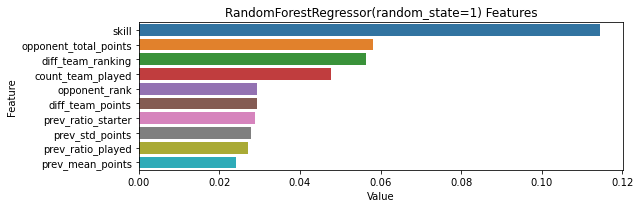

Index(['skill', 'prev_mean_points', 'prev_mean_goals', 'prev_mean_assists',
       'prev_max_points', 'prev_std_points', 'prev_std_assists',
       'prev_ratio_starter', 'count_played', 'goal_consistency',
       'assist_consistency', 'clean_sheet_consistency',
       'star_of_match_consistency', 'star_of_match_count', 'count_team_played',
       'prev_max_goal_to_specific_opp', 'prev_max_points_to_specific_opp',
       'prev_mean_points_to_specific_opp', 'last_three_match_mean_points',
       'last_three_match_std_points', 'last_three_match_max_points',
       'last_three_match_significant_min_play', 'last_three_match_goal_rate',
       'prev_ratio_played', 'team_rank', 'team_total_points', 'opponent_rank',
       'opponent_total_points', 'hth_team_win', 'hth_opp_win',
       'hth_team_score', 'hth_opp_score', 'htt_max_margin',
       'team_mean_squad_age', 'team_market_value', 'team_mean_market_value',
       'opponent_mean_squad_age', 'opponent_market_value',
       'opponent_mean_m

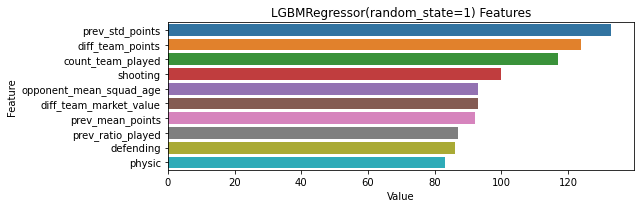

In [28]:
model_1 = get_model(train, dropped_cols, 'roi', model_roi, True)
model_2 = get_model(train, dropped_cols, 'points', model_points, False)

In [29]:
import shap
shap.initjs()

In [30]:
explainer = shap.Explainer(model_2)
shap_obj = explainer(X_test)

In [31]:
def player_to_watch(shap_obj, df, player_name):
    print("Evaluating points for: ", player_name)
    player = df[(df["player"] == player_name)][:1]
    display(player)
    shap.plots.waterfall(shap_obj[player.index[0]])

In [32]:
X_test

,skill,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_assists,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,star_of_match_consistency,star_of_match_count,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,last_three_match_mean_points,last_three_match_std_points,last_three_match_max_points,last_three_match_significant_min_play,last_three_match_goal_rate,prev_ratio_played,team_rank,team_total_points,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,physic,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_imbalanced,big_match,gap_to_potential,more_likely_to_win,position_D,position_F,position_GK,position_M,attacking_work_rate_High,attacking_work_rate_Low,attacking_work_rate_Medium,defending_work_rate_High,defending_work_rate_Low,defending_work_rate_Medium
0,3.0,3.909091,0.0,0.000000,13.0,3.671500,0.000000,0.818182,11.0,0.272727,0.000000,0.272727,0.090909,4.0,30.0,0.0,2.0,2.0,2.000000,0.000000,2.0,3.0,0.000000,0.366667,17.0,1570.0,10.0,1631.0,0.0,2.0,1.0,4.0,2.0,25.6,1.767500e+09,68000000.0,27.7,3.107000e+09,119500000.0,1.0,82.0,82.0,98000.0,3.0,68.0,77.0,79.0,80.0,68.0,73.0,-61.0,7.0,-1.339500e+09,-51500000.0,-2.1,False,False,0.0,False,0,0,0,1,1,0,0,1,0,0
1,3.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,3.0,0.000000,0.000000,1.000000,0.000000,0.0,30.0,NaN,NaN,NaN,0.000000,0.000000,0.0,0.0,0.000000,0.100000,4.0,1686.0,12.0,1609.0,1.0,3.0,4.0,8.0,3.0,25.4,1.250000e+10,498000000.0,27.6,9.365000e+09,360200000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.0,-8.0,3.135000e+09,137800000.0,-2.2,True,True,NaN,False,0,0,0,1,0,0,0,0,0,0
3,1.0,0.400000,0.0,0.000000,1.0,0.547723,0.000000,0.000000,5.0,0.000000,0.000000,0.200000,0.000000,0.0,30.0,NaN,NaN,NaN,0.000000,0.000000,0.0,0.0,0.000000,0.166667,17.0,1570.0,10.0,1631.0,0.0,2.0,1.0,4.0,2.0,25.6,1.767500e+09,68000000.0,27.7,3.107000e+09,119500000.0,2.0,70.0,73.0,12000.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,-61.0,7.0,-1.339500e+09,-51500000.0,-2.1,False,False,3.0,False,0,0,1,0,0,0,1,0,0,1
4,3.0,0.875000,0.0,0.000000,2.0,0.640870,0.000000,0.125000,8.0,0.000000,0.000000,0.250000,0.000000,0.0,30.0,NaN,NaN,NaN,0.333333,0.577350,1.0,1.0,0.000000,0.266667,6.0,1648.0,14.0,1605.0,2.0,2.0,10.0,5.0,6.0,26.5,9.150000e+09,381300000.0,27.8,3.758000e+09,144500000.0,1.0,79.0,85.0,80000.0,1.0,96.0,66.0,68.0,87.0,38.0,81.0,43.0,-8.0,5.392000e+09,236800000.0,-1.3,True,True,6.0,False,0,0,0,1,1,0,0,0,1,0
5,4.0,1.941176,0.0,0.058824,6.0,1.853058,0.242536,0.352941,17.0,0.176471,0.058824,0.058824,0.000000,0.0,29.0,NaN,NaN,NaN,0.333333,0.577350,1.0,1.0,0.000000,0.586207,13.0,1606.0,2.0,1757.0,0.0,1.0,2.0,5.0,3.0,27.0,2.835000e+09,109000000.0,27.9,1.030000e+10,395400000.0,1.0,76.0,76.0,45000.0,2.0,69.0,76.0,71.0,80.0,44.0,67.0,-151.0,11.0,-7.465000e+09,-286400000.0,-0.9,True,True,0.0,False,0,1,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
552,3.0,1.600000,0.0,0.100000,6.0,1.837873,0.316228,0.500000,10.0,0.000000,0.100000,0.100000,0.000000,0.0,28.0,NaN,NaN,NaN,0.000000,0.000000,0.0,0.0,0.000000,0.357143,24.0,1514.0,18.0,1569.0,1.0,1.0,3.0,3.0,1.0,26.4,1.972000e+09,75800000.0,29.2,2.150500e+09,82700000.0,1.0,70.0,70.0,8000.0,1.0,63.0,57.0,69.0,66.0,70.0,67.0,-55.0,6.0,-1.785000e+08,-6900000.0,-2.8,False,False,0.0,False,1,0,0,0,0,0,1,0,0,1
553,3.0,3.333333,0.0,0.148148

In [33]:
test["predicted_roi"] = model_1.predict(X_test.fillna(0))
test["predicted_points"] = model_2.predict(X_test)

## Surfacing The Result

In [34]:
injured = ["Christian Eriksen", "Ben Chilwell", "Dejan Lovren", "Ethan Ampadu", "Thomas Lemar", "Lucas Hernandez"]

In [35]:
fantasy_euro = pd.read_csv("{}/interim/fantasy_euro.csv".format(DATA_DIR))

In [36]:
fantasy_euro = fantasy_euro[["player", "date", "league_name", "team_name", 
                             "opponent_name", "value", "skill", "sel_per"]]

In [37]:
players = pd.merge(test, 
                   fantasy_euro[["player", "sel_per"]],
                   how='left', on="player")

In [38]:
players = players.drop_duplicates(subset=["player", "team_name"])

In [39]:
players["player"] = players["player"].apply(lambda x: re.sub("-", " ", x))

In [40]:
players = players[players['position'] != "0"]
players = players[~players['player'].isin(injured)]

In [41]:
players = players[players["prev_ratio_played"] > 0.1]

In [42]:
scaler = StandardScaler()
players["scaled_points"] = scaler.fit_transform(players["predicted_points"].values.reshape(-1,1))
players["scaled_roi"] = scaler.fit_transform(players["predicted_roi"].values.reshape(-1,1))

In [43]:
players["final_score"] = players["scaled_points"] * 0.8 + players["scaled_roi"] * 0.2

In [44]:
players = players.sort_values(by=["final_score"], ascending=False)

In [45]:
players["match"] = players["team_name"] + ',' + players['opponent_name']
players["match"] = players["match"].apply(lambda x: ' '.join(sorted(x.split(","))))

In [46]:
players["field"] = players["position"].apply(lambda x: "DEF" if x in ["GK", "D"] else "ATTACK")

In [47]:
col = ["player", "team_name", "opponent_name", "position", "value", "predicted_roi", "predicted_points", "final_score", "last_md_points", "prev_max_points", "prev_mean_points", "prev_std_points",'clean_sheet_consistency', 'sel_per']

In [48]:
views = players[col]

In [49]:
views.head(50)

,player,team_name,opponent_name,position,value,predicted_roi,predicted_points,final_score,last_md_points,prev_max_points,prev_mean_points,prev_std_points,clean_sheet_consistency,sel_per
131,Georginio Wijnaldum,Netherlands,Czech Republic,M,8.1,0.773184,6.377550,4.445457,13.0,18.0,5.535714,4.606615,0.392857,19
261,Memphis Depay,Netherlands,Czech Republic,F,10.1,0.660021,5.919996,3.955013,12.0,16.0,5.777778,3.876292,0.333333,26
196,Kevin De Bruyne,Belgium,Portugal,M,10.6,0.687268,5.054258,3.305154,6.0,17.0,6.933333,4.712698,0.466667,20
69,Cristiano Ronaldo,Portugal,Belgium,F,12.2,0.661044,4.787662,3.065152,10.0,18.0,6.272727,4.891020,0.454545,34
313,Raheem Sterling,England,Germany,M,9.6,0.575384,4.884958,3.043011,8.0,18.0,6.850000,5.091531,0.600000,5
108,Eden Hazard,Belgium,Portugal,M,10.0,0.483346,4.537891,2.663851,3.0,15.0,5.882353,3.935136,0.529412,2
133,Gianluigi Donnarumma,Italy,Austria,GK,5.6,0.793645,3.826399,2.461520,6.0,7.0,5.045455,1.914289,0.681818,34
329,Romelu Lukaku,Belgium,Portugal,F,11.2,0.444703,4.283685,2.419289,6.0,13.0,7.157895,3.304259,0.473684,54
174,Jordi Alba,Spain,Croatia,D,6.1,0.512909,4.049556,2.313642,8.0,8.0,5.000000,2.345208,0.333333,14
215,Lorenzo Insigne,Italy,Austria,M,8.6,0.430813,4.123501,2.277234,0.0,10.0,4.823529,2.721105,0.764706,16


## Goalkeeper

In [50]:
views[views["position"] == "GK"]

,player,team_name,opponent_name,position,value,predicted_roi,predicted_points,final_score,last_md_points,prev_max_points,prev_mean_points,prev_std_points,clean_sheet_consistency,sel_per
133,Gianluigi Donnarumma,Italy,Austria,GK,5.6,0.793645,3.826399,2.461520,6.0,7.0,5.045455,1.914289,0.681818,34
325,Robin Olsen,Sweden,Ukraine,GK,5.1,0.857259,3.371763,2.177065,3.0,7.0,3.909091,2.265877,0.409091,3
359,Thibaut Courtois,Belgium,Portugal,GK,6.1,0.532021,3.433842,1.851156,6.0,7.0,4.714286,2.077086,0.619048,23
173,Jordan Pickford,England,Germany,GK,5.6,0.700449,2.921009,1.641679,6.0,7.0,4.900000,2.078995,0.700000,6
194,Kasper Schmeichel,Denmark,Wales,GK,5.0,0.463599,3.225843,1.608640,2.0,7.0,4.074074,2.384661,0.555556,15
378,Unai Simón,Spain,Croatia,GK,5.1,0.503947,3.016196,1.490160,6.0,6.0,3.444444,1.943651,0.333333,3
145,Hugo Lloris,France,Switzerland,GK,6.1,0.473502,2.922930,1.381688,0.0,7.0,4.045455,2.439307,0.454545,8
102,Dominik Livakovic,Croatia,Spain,GK,5.0,0.467021,2.390980,0.955627,3.0,7.0,3.142857,1.878449,0.238095,1
79,Danny Ward,Wales,Denmark,GK,4.7,0.575259,2.028058,0.794759,4.0,7.0,4.181818,2.482667,0.454545,2
331,Rui Patrício,Portugal,Belgium,GK,5.6,0.279437,2.158576,0.556600,2.0,7.0,4.181818,2.519190,0.500000,6


Evaluating points for:  Gianluigi Donnarumma


,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,is_star_of_match,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,star_of_match_consistency,star_of_match_count,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,last_three_match_mean_points,last_three_match_std_points,last_three_match_max_points,last_three_match_significant_min_play,last_three_match_goal_rate,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,big_match,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate,predicted_roi,predicted_points
177,Gianluigi Donnarumma,2021-06-26 21:00:00,European Championship 2020,Italy,Austria,NaN,NaN,GK,2021.0,6.0,26.0,NaN,NaN,5.6,1.0,6.0,0.0,0.0,5.045455,0.0,0.0,7.0,1.914289,0.0,0.0,90.0,1.0,22.0,0.0,0.0,0.681818,0.181818,4.0,30.0,NaN,NaN,NaN,6.0,0.0,6.0,3.0,0.0,0.733333,7.0,7.0,1642.0,22.0,23.0,1523.0,0.0,0.0,0.0,0.0,0.0,NaN,27.8,7.640000e+09,293800000.0,27.9,3.206000e+09,123300000.0,21.0,196.0,90.0,1.0,85.0,92.0,34000.0,3.0,NaN,NaN,NaN,NaN,NaN,GK,21.0,NaN,12.0,12.0,12.0,34.0,8.0,28.0,12.0,14.0,24.0,28.0,46.0,54.0,64.0,79.0,38.0,57.0,72.0,34.0,72.0,18.0,30.0,26.0,14.0,50.0,24.0,68.0,14.0,16.0,89.0,81.0,76.0,83.0,89.0,119.0,-16.0,4.434000e+09,170500000.0,-0.1,False,True,False,7.0,NaN,False,Medium,Medium,0.793645,3.826399


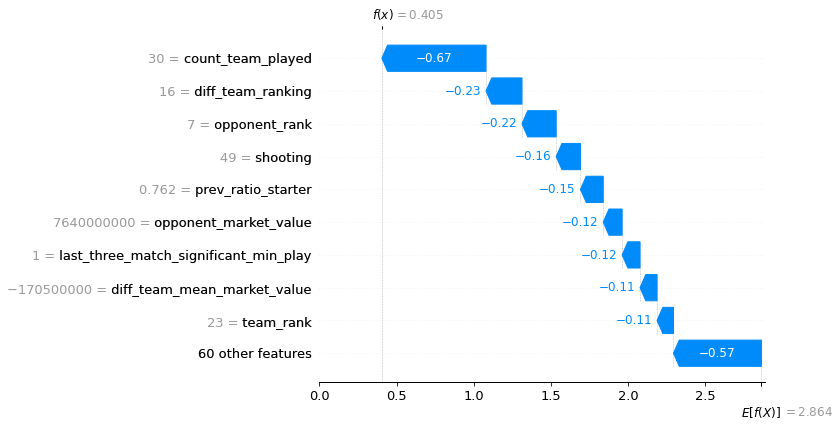

In [51]:
player_to_watch(shap_obj, test, "Gianluigi Donnarumma")

## Defender

In [52]:
views[(views["position"] == "D")].head(20)

,player,team_name,opponent_name,position,value,predicted_roi,predicted_points,final_score,last_md_points,prev_max_points,prev_mean_points,prev_std_points,clean_sheet_consistency,sel_per
174,Jordi Alba,Spain,Croatia,D,6.1,0.512909,4.049556,2.313642,8.0,8.0,5.000000,2.345208,0.333333,14
71,Daley Blind,Netherlands,Czech Republic,D,5.2,0.714884,3.543341,2.148028,6.0,9.0,3.423077,2.670926,0.346154,4
259,Matthijs de Ligt,Netherlands,Czech Republic,D,5.5,0.646884,3.491916,2.029207,6.0,9.0,4.045455,2.785631,0.454545,13
380,Victor Lindelöf,Sweden,Ukraine,D,5.6,0.637820,3.283599,1.854837,1.0,12.0,4.000000,3.629941,0.444444,3
212,Leonardo Bonucci,Italy,Austria,D,5.6,0.640291,3.073499,1.692355,1.0,12.0,4.750000,2.690563,0.625000,13
134,Giorgio Chiellini,Italy,Austria,D,6.0,0.383178,3.379951,1.637243,0.0,6.0,3.769231,2.420532,0.692308,3
265,Mikael Lustig,Sweden,Ukraine,D,5.2,0.800146,2.747647,1.620136,2.0,9.0,4.266667,2.433888,0.533333,0
315,Raphael Varane,France,Switzerland,D,6.1,0.574745,2.905841,1.484899,1.0,8.0,3.851852,2.429050,0.407407,14
78,Daniel Wass,Denmark,Wales,D,5.0,0.422867,3.057071,1.428900,6.0,9.0,4.400000,2.693908,0.533333,0
221,Ludwig Augustinsson,Sweden,Ukraine,D,5.6,0.557482,2.650604,1.264161,1.0,12.0,4.000000,3.207135,0.533333,0


## Midfielder

In [53]:
views[(views["position"] == "M")].head(30)

,player,team_name,opponent_name,position,value,predicted_roi,predicted_points,final_score,last_md_points,prev_max_points,prev_mean_points,prev_std_points,clean_sheet_consistency,sel_per
131,Georginio Wijnaldum,Netherlands,Czech Republic,M,8.1,0.773184,6.377550,4.445457,13.0,18.0,5.535714,4.606615,0.392857,19
196,Kevin De Bruyne,Belgium,Portugal,M,10.6,0.687268,5.054258,3.305154,6.0,17.0,6.933333,4.712698,0.466667,20
313,Raheem Sterling,England,Germany,M,9.6,0.575384,4.884958,3.043011,8.0,18.0,6.850000,5.091531,0.600000,5
108,Eden Hazard,Belgium,Portugal,M,10.0,0.483346,4.537891,2.663851,3.0,15.0,5.882353,3.935136,0.529412,2
215,Lorenzo Insigne,Italy,Austria,M,8.6,0.430813,4.123501,2.277234,0.0,10.0,4.823529,2.721105,0.764706,16
112,Emil Forsberg,Sweden,Ukraine,M,7.7,0.696320,3.480246,2.076986,12.0,12.0,3.777778,2.819169,0.388889,3
0,Aaron Ramsey,Wales,Denmark,M,8.6,0.384095,3.288834,1.566599,0.0,13.0,3.909091,3.671500,0.272727,1
175,Jorginho,Italy,Austria,M,6.1,0.450488,2.922162,1.354565,3.0,10.0,3.833333,2.757909,0.583333,5
281,Nicolò Barella,Italy,Austria,M,7.2,0.407319,2.939716,1.318638,0.0,9.0,3.666667,2.530968,0.625000,3
237,Marco Verratti,Italy,Austria,M,6.5,0.453430,2.867722,1.315117,6.0,8.0,2.833333,2.255712,0.777778,1


## Forward

In [54]:
views[views["position"] == "F"].head(20)

,player,team_name,opponent_name,position,value,predicted_roi,predicted_points,final_score,last_md_points,prev_max_points,prev_mean_points,prev_std_points,clean_sheet_consistency,sel_per
261,Memphis Depay,Netherlands,Czech Republic,F,10.1,0.660021,5.919996,3.955013,12.0,16.0,5.777778,3.876292,0.333333,26
69,Cristiano Ronaldo,Portugal,Belgium,F,12.2,0.661044,4.787662,3.065152,10.0,18.0,6.272727,4.891020,0.454545,34
329,Romelu Lukaku,Belgium,Portugal,F,11.2,0.444703,4.283685,2.419289,6.0,13.0,7.157895,3.304259,0.473684,54
64,Ciro Immobile,Italy,Austria,F,10.1,0.466884,3.384424,1.737214,0.0,13.0,4.187500,3.581783,0.562500,21
141,Harry Kane,England,Germany,F,11.5,0.393521,3.438424,1.695174,2.0,17.0,5.076923,4.408384,0.500000,23
239,Marcus Berg,Sweden,Ukraine,F,8.5,0.376662,3.241487,1.520777,1.0,9.0,2.800000,2.081666,0.400000,0
396,Yussuf Poulsen,Denmark,Wales,F,8.2,0.453864,3.100181,1.498539,6.0,6.0,2.833333,1.685402,0.416667,2
208,Kylian Mbappé,France,Switzerland,F,12.0,0.412885,3.124388,1.470370,4.0,12.0,3.739130,3.018389,0.304348,34
34,Antoine Griezmann,France,Switzerland,F,11.1,0.471236,2.965261,1.412387,1.0,10.0,3.967742,3.016442,0.419355,5
248,Martin Braithwaite,Denmark,Wales,F,7.5,0.568872,2.703629,1.319010,2.0,6.0,3.037037,1.697996,0.444444,1


## Selecting the Team

In [55]:
players = players.reset_index(drop=True)

In [56]:
def make_decision_variables(player_df):
    return [pulp.LpVariable(i, cat="Binary") for i in player_df.player]

In [57]:
def make_optimization_function(player_df, decision_variables):
    op_func = ""

    for i, player in enumerate(decision_variables):
        op_func += player_df.final_score[i]*player
        
    return op_func

In [58]:
def make_cash_constraint(player_df, decision_variables, available_cash):
    total_paid = ""
    for rownum, row in player_df.iterrows():
        for i, player in enumerate(decision_variables):
            if rownum == i:
                total_paid += row.value*player

    return (total_paid <= available_cash)

In [59]:
def make_player_constraint(position, n, decision_variables, player_df):
    
    total_n = ""
    
    player_positions = player_df.position
    
    for i, player in enumerate(decision_variables):
        if player_positions[i] == position:
            total_n += 1*player
            
    return(total_n == n)

In [60]:
def add_team_constraint(prob, player_df, decision_variables):

    for team, group in player_df.groupby('team_name'):
        team_total = ''
        for player in decision_variables:
            if re.sub("_", " ", player.name) in group.player.values:
                formula = 1*player
                team_total += formula

        prob += (team_total <= 4)

In [61]:
def add_match_constraint(prob, player_df, decision_variables):

    for team, group in player_df.groupby('match'):
        team_total = ''
        for player in decision_variables:
            if re.sub("_", " ", player.name) in group.player.values:
                formula = 1*player
                team_total += formula

        prob += (team_total <= 4)

In [62]:
available_cash = 105

prob = pulp.LpProblem('InitialTeam', pulp.LpMaximize)

decision_variables = make_decision_variables(players)
prob += make_optimization_function(players, decision_variables)
prob += make_cash_constraint(players, decision_variables, available_cash)
prob += make_player_constraint("GK", 2, decision_variables, players) 
prob += make_player_constraint("D", 5, decision_variables, players) 
prob += make_player_constraint("M", 5, decision_variables, players) 
prob += make_player_constraint("F", 3, decision_variables, players)
add_team_constraint(prob, players, decision_variables)
add_match_constraint(prob, players, decision_variables)

In [63]:
prob.writeLP('InitialTeam.lp')
optimization_result = prob.solve()

In [64]:
def get_initial_team(prob, player_df):
    
    variable_names = [re.sub("_", " ", v.name) for v in prob.variables()]
    variable_values = [v.varValue for v in prob.variables()]
    
    initial_team = pd.merge(pd.DataFrame({'player': variable_names,
                                          'selected': variable_values}),
                                           player_df, on="player")
    
    initial_team = initial_team[initial_team.selected==1.0] 
    
    return initial_team

In [65]:
initial_team_df = get_initial_team(prob, players)
initial_team_df[['player', "position", "value", "team_name", "predicted_points"]].sort_values("position")

,player,position,value,team_name,predicted_points
61,Daley Blind,D,5.2,Netherlands,3.543341
64,Daniel Wass,D,5.0,Denmark,3.057071
155,Jordi Alba,D,6.1,Spain,4.049556
237,Matthijs de Ligt,D,5.5,Netherlands,3.491916
243,Mikael Lustig,D,5.2,Sweden,2.747647
227,Martin Braithwaite,F,7.5,Denmark,2.703629
239,Memphis Depay,F,10.1,Netherlands,5.919996
371,Yussuf Poulsen,F,8.2,Denmark,3.100181
115,Gianluigi Donnarumma,GK,5.6,Italy,3.826399
301,Robin Olsen,GK,5.1,Sweden,3.371763


In [66]:
initial_team_df["value"].sum()

104.99999999999999

In [67]:
initial_team_df["predicted_points"].sum()

58.300281406227946